In [1]:
# ---------- INSTALLATION AND IMPORTATION ----------

!pip install googleapis-common-protos protobuf grpcio pandas systemathics.apis
!pip install sklearn
!pip install kneed
!pip install statsmodels

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
import scipy.cluster.hierarchy as shc
from itertools import cycle
from sklearn import metrics
from kneed import KneeLocator
import numpy as np
import pandas as pd
import pair_selection
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
s = pair_selection.Selection(start_date="2015-01-01") # adjustment=False

/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


In [4]:
s.df_all_prices

,Dates,MELI,SPLK,MRVL,LULU,SIRI,WDAY,PANW,SGEN,CPRT,...,DISCB,APA,HOLX,HSIC,AKAM,HAS,EQIX,HST,INCY,AAL
66,2015-01-02,125.85,58.790,14.520,55.34,3.475,80.41,121.42,32.54,18.290,...,36.1001,63.83,26.380,53.075286,63.25,54.97,226.65,23.81,73.76,53.910
67,2015-01-05,124.30,56.840,14.280,55.96,3.400,80.01,123.73,33.05,18.110,...,36.1001,59.91,26.120,52.600136,61.94,55.13,224.32,23.62,74.22,53.875
68,2015-01-06,122.08,55.780,14.825,55.57,3.350,79.42,121.85,31.45,17.905,...,36.1001,59.26,25.745,52.293712,60.67,54.41,219.43,23.52,71.49,53.040
69,2015-01-07,121.84,56.245,15.040,57.65,3.410,79.35,125.53,32.15,17.960,...,36.1001,58.60,26.400,53.740497,60.16,54.67,220.15,23.65,74.45,53.010
70,2015-01-08,123.66,58.450,16.015,59.07,3.540,82.78,127.21,31.74,18.145,...,36.1001,60.87,27.110,54.496859,61.57,55.00,222.78,23.90,73.21,53.660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,2022-01-13,1131.01,120.400,78.650,336.27,6.360,249.41,498.60,136.79,138.550,...,39.7900,32.09,69.960,77.860000,112.91,102.02,748.12,18.07,73.65,19.340
1838,2022-01-14,1122.74,122.620,83.000,328.98,6.180,254.31,499.11,137.09,136.710,...,39.8200,33.29,69.590,77.780000,112.62,100.12,746.76,17.94,74.88,18.490
1839,2022-01-18,1100.75,118.050,77.670,332.53,6.110,245.86,502.37,130.29,132.940,...,37.8100,32.97,69.410,76.270000,112.08,100.13,742.94,17.70,75.01,17.900
1840,2022-01-19,1060.94,118.780,76.890,330.95,6.100,249.46,519.61,132.55,131.900,...,36.0000,32.38,70.420,74.550000,113.17,99.13,730.49,17.35,74.78,17.310


In [5]:
data = s.df_all_prices
data1 = data
data.set_index('Dates', inplace=True)
data

,MELI,SPLK,MRVL,LULU,SIRI,WDAY,PANW,SGEN,CPRT,PAYX,...,DISCB,APA,HOLX,HSIC,AKAM,HAS,EQIX,HST,INCY,AAL
Dates,,,,,,,,,,,,,,,,,,,,,
2015-01-02,125.85,58.790,14.520,55.34,3.475,80.41,121.42,32.54,18.290,46.24,...,36.1001,63.83,26.380,53.075286,63.25,54.97,226.65,23.81,73.76,53.910
2015-01-05,124.30,56.840,14.280,55.96,3.400,80.01,123.73,33.05,18.110,46.32,...,36.1001,59.91,26.120,52.600136,61.94,55.13,224.32,23.62,74.22,53.875
2015-01-06,122.08,55.780,14.825,55.57,3.350,79.42,121.85,31.45,17.905,45.99,...,36.1001,59.26,25.745,52.293712,60.67,54.41,219.43,23.52,71.49,53.040
2015-01-07,121.84,56.245,15.040,57.65,3.410,79.35,125.53,32.15,17.960,46.83,...,36.1001,58.60,26.400,53.740497,60.16,54.67,220.15,23.65,74.45,53.010
2015-01-08,123.66,58.450,16.015,59.07,3.540,82.78,127.21,31.74,18.145,47.56,...,36.1001,60.87,27.110,54.496859,61.57,55.00,222.78,23.90,73.21,53.660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-13,1131.01,120.400,78.650,336.27,6.360,249.41,498.60,136.79,138.550,126.63,...,39.7900,32.09,69.960,77.860000,112.91,102.02,748.12,18.07,73.65,19.340
2022-01-14,1122.74,122.620,83.000,328.98,6.180,254.31,499.11,137.09,136.710,125.00,...,39.8200,33.29,69.590,77.780000,112.62,100.12,746.76,17.94,74.88,18.490
2022-01-18,1100.75,118.050,77.670,332.53,6.110,245.86,502.37,130.29,132.940,123.03,...,37.8100,32.97,69.410,76.270000,112.08,100.13,742.94,17.70,75.01,17.900


In [7]:
# pd.set_option('precision', 3)
data.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
MELI,1776.0,565.075709,519.388398,85.82,166.8400,337.200,676.37500,1984.34
SPLK,1776.0,104.223266,45.051103,30.86,61.0800,103.875,134.95250,223.59
MRVL,1776.0,25.583857,16.928659,7.77,14.6975,20.335,27.00250,91.51
LULU,1776.0,164.974935,120.679434,44.09,63.9850,123.555,243.72500,477.91
SIRI,1776.0,5.436940,1.067605,3.35,4.1900,5.735,6.24625,7.64
WDAY,1776.0,145.885090,64.290390,48.90,84.7375,131.045,194.34000,300.90
PANW,1776.0,217.232534,98.808357,108.01,147.5250,189.015,239.31750,568.34
SGEN,1776.0,86.006447,48.746648,26.87,49.6675,66.320,132.67750,211.93
CPRT,1776.0,61.554185,40.456533,16.45,26.4825,50.765,88.45750,159.10
PAYX,1776.0,71.818190,20.006676,42.92,56.9625,67.115,84.11500,137.38


In [8]:
data.isnull().values.any()

False

In [9]:
#Calculate returns and create a data frame
returns = data.pct_change().mean()*266
returns = pd.DataFrame(returns)
returns.columns = ['returns']

#Calculate the volatility
returns['volatility'] = data.pct_change().std()*np.sqrt(266)

data = returns
data.head()

,returns,volatility
MELI,0.432061,0.467457
SPLK,0.208453,0.451919
MRVL,0.326824,0.407994
LULU,0.341824,0.391163
SIRI,0.120022,0.271634


In [10]:
#Prepare the scaler
scale = StandardScaler().fit(data)

#Fit the scaler
scaled_data = pd.DataFrame(scale.fit_transform(data), columns=data.columns, index=data.index)
X = scaled_data
X.head()

,returns,volatility
MELI,1.524954,1.200754
SPLK,-0.107312,1.048412
MRVL,0.756758,0.617778
LULU,0.866254,0.452768
SIRI,-0.752829,-0.719088


# KMeans Clustering

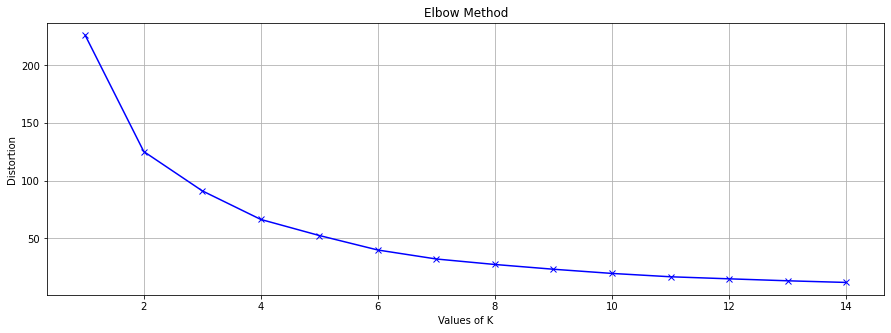

In [11]:
K = range(1,15)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [12]:
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
kl.elbow

4

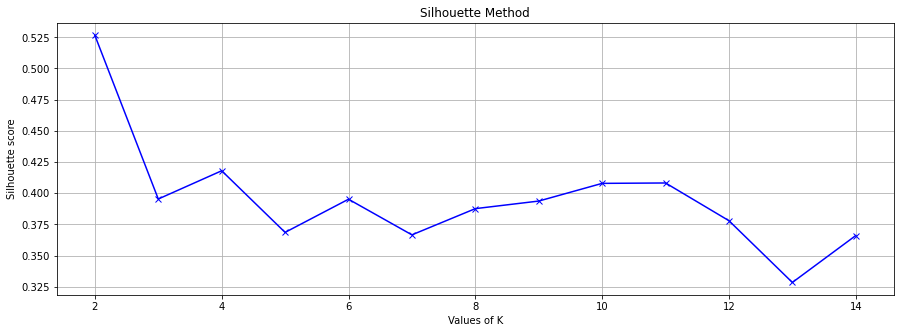

Suggested number of clusters:  3


In [13]:
#For the silhouette method k needs to start from 2
K = range(2,15)
silhouettes = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

#Plot the results
fig = plt.figure(figsize=(15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

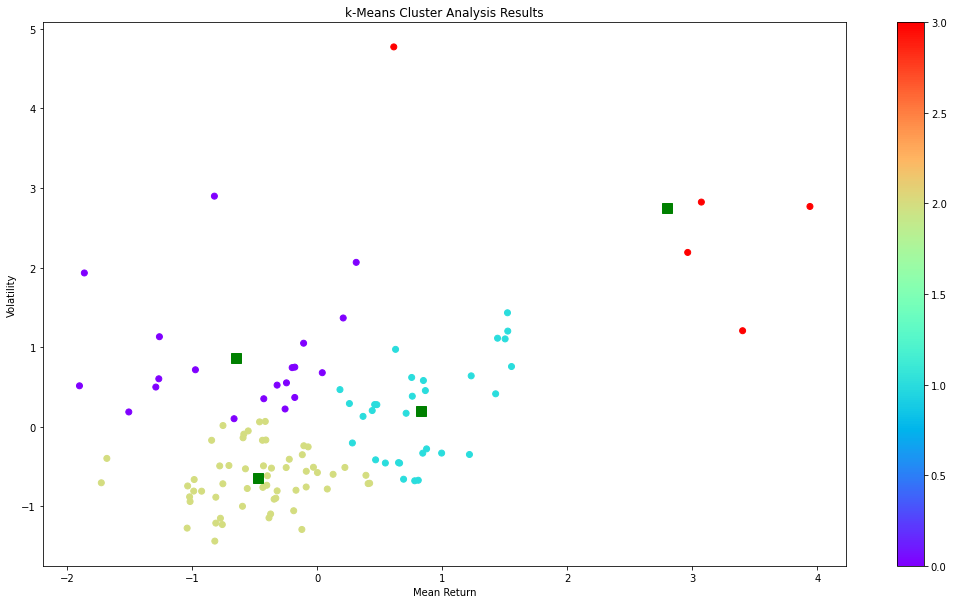

In [14]:
c = 4
#Fit the model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(X)

#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = X.index)
ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
plt.show()

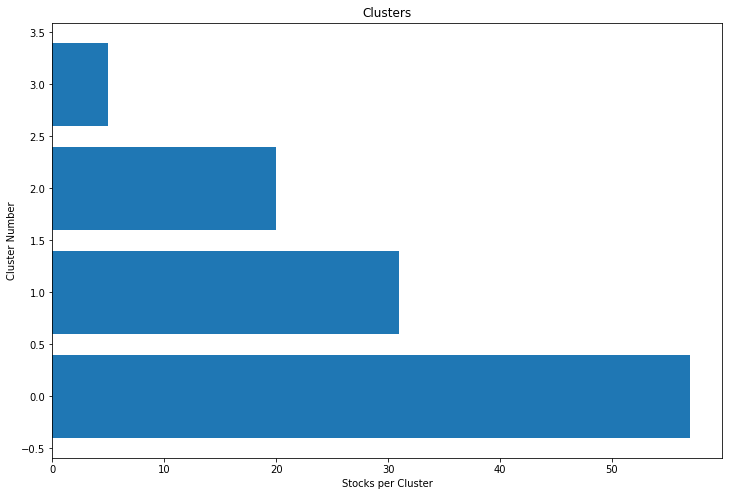

In [15]:
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

# Hierarchical Clustering

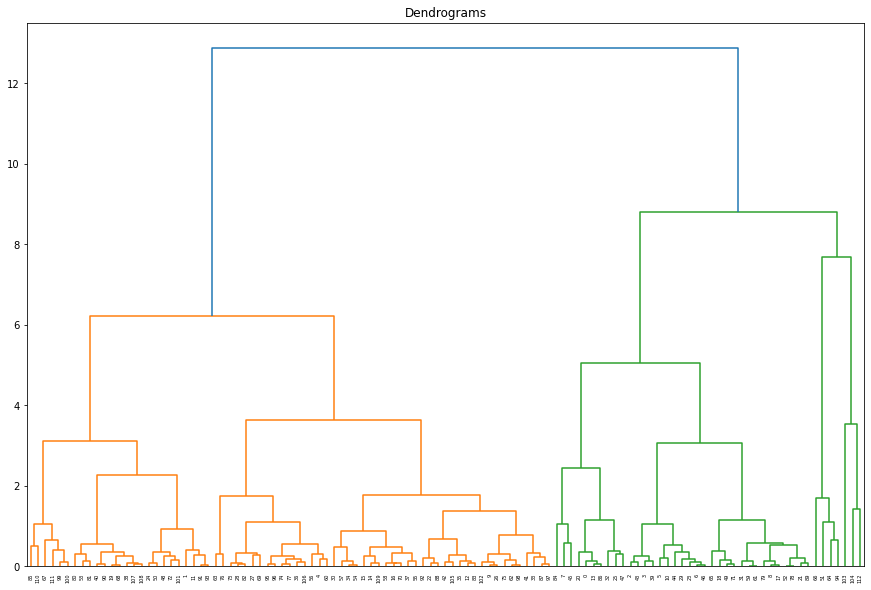

In [16]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))


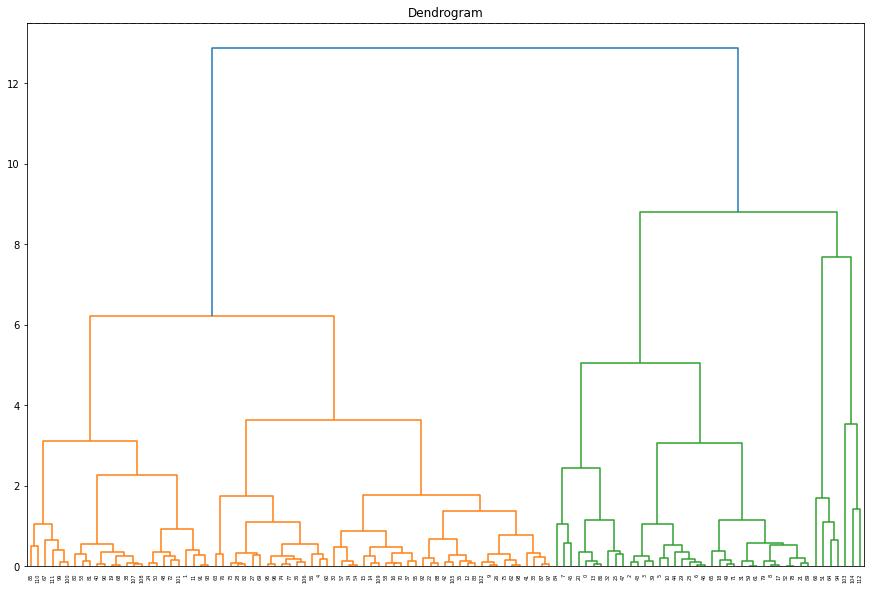

In [17]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.axhline(y=13.5, color='purple', linestyle='--')

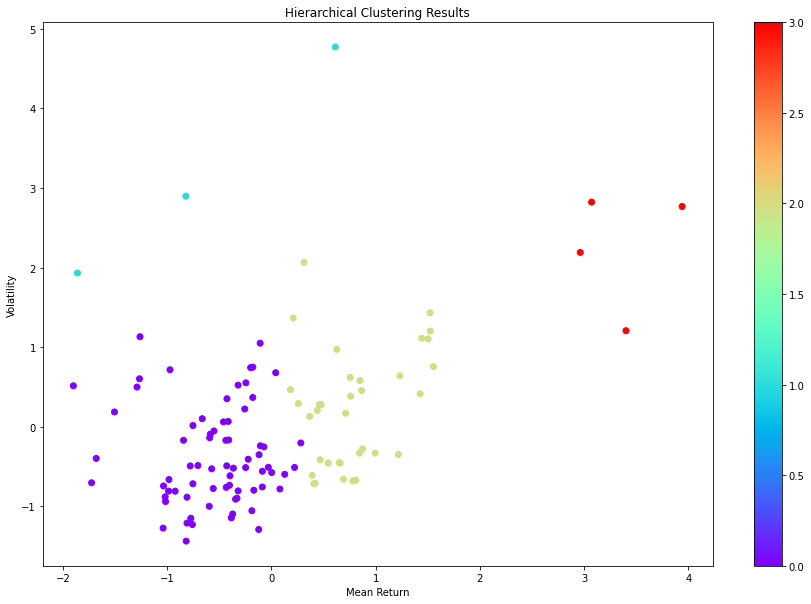

In [18]:
#Fit the model
clusters = 4
hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage='ward')
labels = hc.fit_predict(X)

#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Hierarchical Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Affinity Propagation Clustering

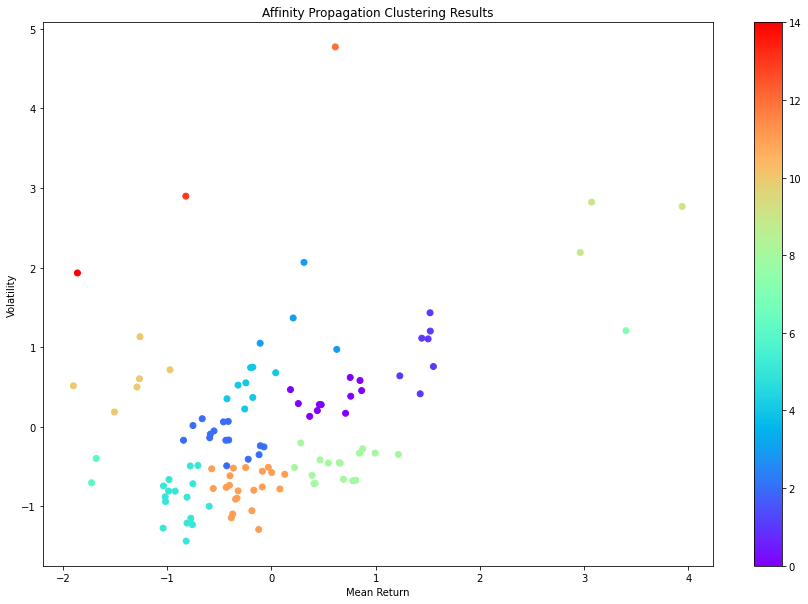

In [19]:
ap = AffinityPropagation()
ap.fit(X)
labels1 = ap.predict(X)

#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels1, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

The number of clusters is: 15


<Figure size 432x288 with 0 Axes>

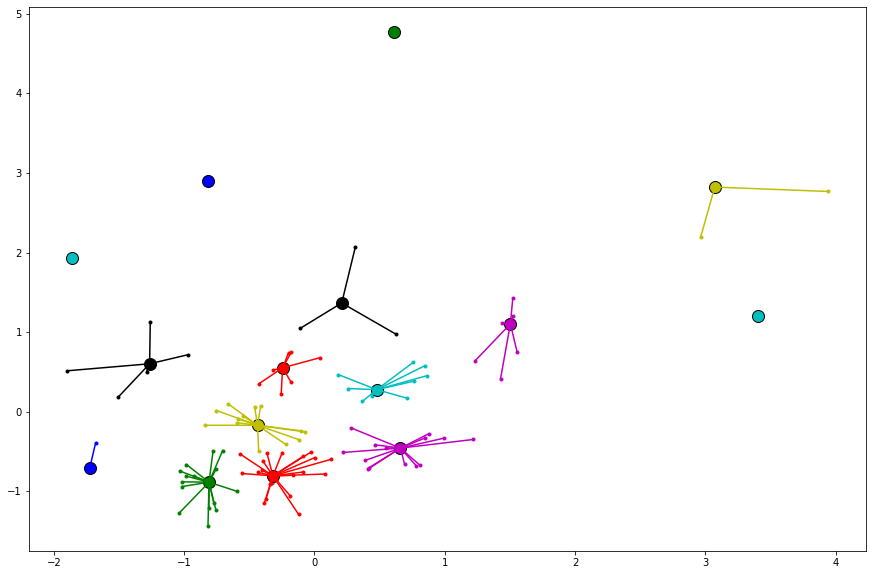

In [20]:
#Extract the cluster centers and labels
cci = ap.cluster_centers_indices_
labels2 = ap.labels_

#Print their number
clusters = len(cci)
print('The number of clusters is:',clusters)

#Plot the results
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels2 == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

# Compare clustering models

In [21]:
print("k-Means Clustering", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("Hierarchical Clustering", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("Affinity Propagation Clustering", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

k-Means Clustering 0.4139433408285051
Hierarchical Clustering 0.3973133577592941
Affinity Propagation Clustering 0.39862957785669323


# Extract the trading pairs

In [22]:
cluster_size_limit = 1000
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 4
Number of Pairs: 4522


In [23]:
def find_cointegrated_pairs(data, significance=0.05):
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [26]:
from statsmodels.tsa.stattools import coint

cluster_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(data1[tickers])
    cluster_dict[clust] = {}
    cluster_dict[clust]['score_matrix'] = score_matrix
    cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[clust]['pairs'] = pairs
    
pairs = []   
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])
    
print ("Number of pairs:", len(pairs))
print ("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
print(pairs)

Number of pairs: 6
In those pairs, we found 9 unique tickers.
[('SIRI', 'MAR'), ('SIRI', 'GILD'), ('SIRI', 'INTC'), ('MELI', 'SGEN'), ('SPLK', 'VRTX'), ('SPLK', 'APA')]


___

# Get best pairs function

In [30]:
from statsmodels.tsa.stattools import coint

In [44]:
s = pair_selection.Selection(start_date="2015-01-01") # adjustment=False

/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


In [45]:
def get_best_pairs(df_prices, start_date='', end_date=''):
    # Retrieve only the prices between the two specified dates
    mask = (df_prices['Dates'] >= start_date) & (df_prices['Dates'] <= end_date)
    data = df_prices.loc[mask]
    
    data.set_index('Dates', inplace=True)
    data1 = data.copy(deep=True)
    
    #Calculate returns and create a data frame
    returns = data.pct_change().mean()*266
    returns = pd.DataFrame(returns)
    returns.columns = ['returns']

    #Calculate the volatility
    returns['volatility'] = data.pct_change().std()*np.sqrt(266)

    data = returns
    
    #Prepare the scaler
    scale = StandardScaler().fit(data)

    #Fit the scaler
    scaled_data = pd.DataFrame(scale.fit_transform(data), columns=data.columns, index=data.index)
    X = scaled_data
    
    K = range(1,15)
    distortions = []

    #Fit the method
    for k in K:
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    
    kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
    c = kl.elbow

    #Fit the model
    k_means = KMeans(n_clusters=c)
    k_means.fit(X)
    prediction = k_means.predict(X)
    
    clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
    clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
    clustered_series = clustered_series[clustered_series != -1]
    
    cluster_size_limit = 1000
    counts = clustered_series.value_counts()
    ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
    
    cluster_dict = {}

    for i, clust in enumerate(ticker_count.index):
        tickers = clustered_series[clustered_series == clust].index
        score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(data1[tickers])
        cluster_dict[clust] = {}
        cluster_dict[clust]['score_matrix'] = score_matrix
        cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
        cluster_dict[clust]['pairs'] = pairs

    pairs = []   
    for cluster in cluster_dict.keys():
        pairs.extend(cluster_dict[cluster]['pairs'])

    # print ("Number of pairs:", len(pairs))
    # print ("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
    # print(pairs)
    return pairs

In [46]:
prices = s.df_all_prices
top = get_best_pairs(prices, "2015-01-01", "2022-01-23")

In [47]:
top

[('SIRI', 'MAR'),
 ('SIRI', 'GILD'),
 ('SIRI', 'INTC'),
 ('MELI', 'SGEN'),
 ('SPLK', 'VRTX'),
 ('SPLK', 'APA')]

In [51]:
l = [[top[i][0], top[i][1]] for i in range(len(top))]
l

[['SIRI', 'MAR'],
 ['SIRI', 'GILD'],
 ['SIRI', 'INTC'],
 ['MELI', 'SGEN'],
 ['SPLK', 'VRTX'],
 ['SPLK', 'APA']]

# Get all time best pairs

In [67]:
from statsmodels.tsa.stattools import coint
from dateutil.relativedelta import relativedelta
from datetime import datetime, date
import json

In [68]:
start_date="2015-01-01"
interval=6
repetition=1
filename="ml_best_pairs"

In [69]:
s = pair_selection.Selection(start_date=start_date) 

/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


In [70]:
def add_months(start_date, interval):
    """From a starting date in string format 'YYYY-MM-DD', return the same format date after an interval of X month(s) later."""
    date_format = '%Y-%m-%d'
    dtObj = datetime.strptime(start_date, date_format)
    # Add months to a given datetime object
    future_date = dtObj + relativedelta(months=interval)
    # Convert datetime object to string in required format
    future_date_str = future_date.strftime(date_format)
    return future_date_str

In [71]:
end_date = add_months(start_date, interval)
prices = s.df_all_prices

# To know when to stop the loop: the month and year of the last saved price
last_date = prices.iloc[-1]['Dates'] 
last_year = last_date.strftime('%Y')
last_month = last_date.strftime('%m')

best_pairs_dict = {}
while True:
    # Get the best pairs of a specific period
    top = get_best_pairs(prices, start_date, end_date)
    best_pairs_dict[end_date] = [[top[i][0], top[i][1]] for i in range(len(top))]
    # increment start and end for the get_best_pairs() computation
    start_date = add_months(start_date, repetition)
    end_date = add_months(end_date, repetition)
    # check if we've reached the month and year of the last saved price
    splt = end_date.split('-')    
    if splt[0] == last_year and splt[1] == last_month:
        break

# Save the results in a json for backtesting purpose
with open(filename + ".json", "w") as f:
    json.dump(best_pairs_dict, f)